# Different delay widths

In this notebook we want to analyse the effect of different priors for the delay width.

In [1]:
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

sys.path.append("../")
sys.path.append("../covid19_inference")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
""" Matplotlib config
"""
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams["figure.figsize"] = [3.4, 2.7]  # APS single column
matplotlib.rcParams["figure.dpi"] = 300  # this primarily affects the size on screen
#matplotlib.rcParams['axes.linewidth'] = 0.3
matplotlib.rcParams["axes.labelcolor"] = "black"
matplotlib.rcParams["axes.edgecolor"] = "black"
matplotlib.rcParams["xtick.color"] = "black"
matplotlib.rcParams["ytick.color"] = "black"
matplotlib.rcParams["xtick.labelsize"] = 8
matplotlib.rcParams["ytick.labelsize"] = 8
matplotlib.rcParams["axes.labelsize"] = 8
matplotlib.rcParams["axes.titlesize"]= 10
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["legend.title_fontsize"] = 8

# Save figure  keyword args   
save_kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}
fig_path = "./figures"

def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)


In [8]:
countries = [
    'England',
    "Czechia",
    "Italy",
    'Scotland',
    "Spain",
    "Germany",
    "France"
]
from tqdm import tqdm
import os
tune = 500
draws = 1000
max_treedepth = 12
traces, models, dls = {}, {}, {}
for country in tqdm(countries):
    models_t, traces_t, dls_t = [],[],[]
    for f_fem in [0.2, 0.5]:
        fstr=lambda tune, draws, max_treedepth: (f"/data.nst/jdehning/covid_uefa_traces11/UEFA"+
            f"-beta=False"+
            f"-country={country}"+
            f"-offset_data=0"+
            f"-draw_delay=True"+
            f"-weighted_alpha_prior=0"+
            f"-prior_delay=-1"+
            f"-width_delay_prior=0.1"+
            f"-sigma_incubation=-1.0"+
            f"-median_width_delay={1.0}"+
            f"-interval_cps={10.0}"+
            f"-f_fem={f_fem}"+
            f"-len=normal"+
            f"-tune={tune}"+
            f"-draws={draws}"+
            f"-max_treedepth={max_treedepth}.pickled")
        if os.path.exists(fstr(tune, draws, max_treedepth)):
            model, trace = load(fstr(tune, draws, max_treedepth))
        elif os.path.exists(fstr(200, 300, 10)):
            print(f"Use short runs for {country}")
            model, trace = load(fstr(200, 300, 10))
        else: 
            print(fstr(tune, draws, max_treedepth), " not found")
            continue
        dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
        models_t.append(model)
        traces_t.append(trace)
        dls_t.append(dl)
    models[country] = models_t
    traces[country] = traces_t
    dls[country] = dls_t

100%|██████████| 7/7 [01:26<00:00, 12.36s/it]


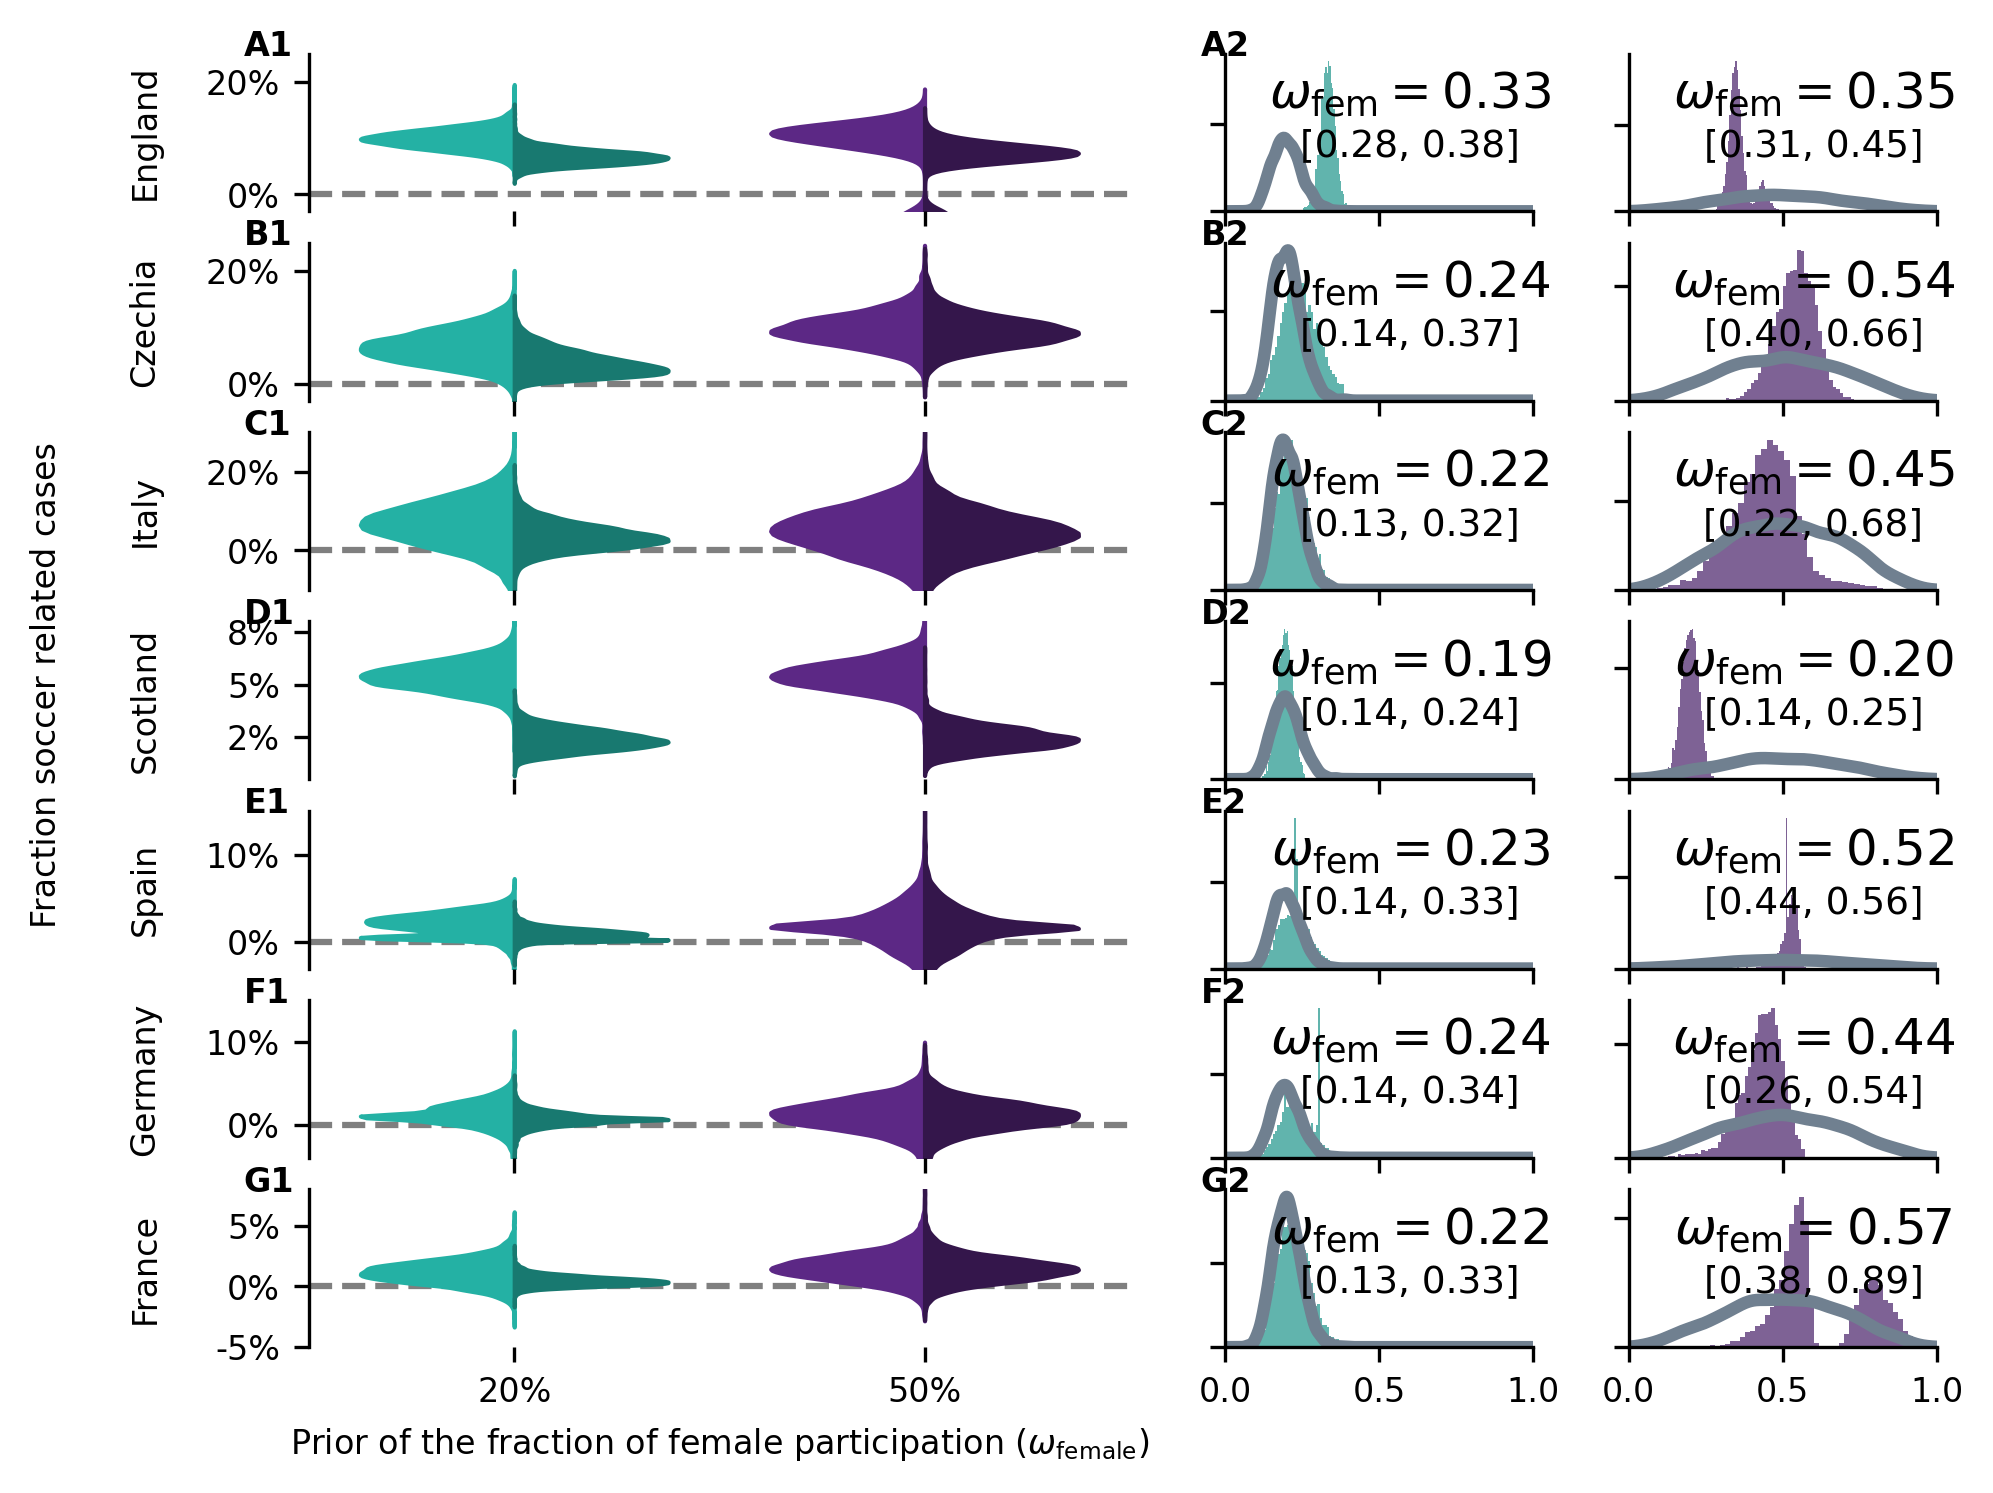

In [9]:
from covid19_soccer.plot.utils import lighten_color
from covid19_soccer.plot.rcParams import *
from matplotlib.colors import to_hex
fig, axes = plt.subplots(len(countries),3,figsize=(7,len(countries)*0.8),gridspec_kw={"width_ratios":[0.8,0.3,0.3]})

colors_base = [#"#ffe530",
              "#1e958a","#481f68"]
l = 0.9
d = 1.1

colors_mf = []
for col in colors_base:
    colors_mf.append(to_hex(lighten_color(col,l)))
    colors_mf.append(to_hex(lighten_color(col,d)))
colors_mf = np.array(colors_mf)

for i, country in enumerate(countries):
    covid19_soccer.plot.other.soccer_related_cases_overview(
        ax=axes[i,0],
        traces=traces[country],
        models=models[country],
        dls=dls[country],
        country_order=[0,1],
        colors=colors_mf
        
        )
    axes[i,0].set_xticklabels(["20%","50%"])
    axes[i,0].set_ylabel(dls[country][0].countries[0])
    axes[i,0].yaxis.set_label_coords(-0.18, 0.5)

    if i != len(countries)-1:
        axes[i,0].set_xticklabels([])

    for j, (trace, model , dl, color,ls) in enumerate(zip(traces[country], models[country], dls[country], colors_base, [(0, (5, 7)),"dashed","-"])):
        
        if j == 2:
            axes[i,j+1].set_xlim(0,1)
        else:
            axes[i,j+1].set_xlim(0,1)
        rcParams.color_posterior=colors_base[j]
        covid19_soccer.plot.distributions.distribution(
            model,
            trace,
            "factor_female",
            nSamples_prior=5000,
            title="",
            dist_math="\omega_\mathrm{fem}",
            ax=axes[i,j+1],
        )
        if i != len(countries)-1:
            axes[i,j+1].set_xticklabels([])
    #axes[i,1].set_ylim(0.6,2)
    #axes[i,1].set_yticks([1,1.5])
    #axes[i,1].yaxis.set_label_coords(-0.12, 0.5)
# Array of capital letters
letters = np.array(list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"))

# Add label letters to figure
for i, country in enumerate(countries):
    axes[i,0].text(
        -0.08,
        1.15,
        letters[i]+"1",
        transform=axes[i,0].transAxes,
        fontsize=8,
        fontweight="bold",
        verticalalignment="top"
    )
    axes[i,1].text(
        -0.08,
        1.15,
        letters[i]+"2",
        transform=axes[i,1].transAxes,
        fontsize=8,
        fontweight="bold",
        verticalalignment="top"
    )
# set ylims
ylims = {
    "England":[-3,25],
    "Czechia":[-3,25],
    "Italy":[-10,30],
    "Scotland":[0.5,8],
    "Spain":[-3,15],
    "Germany":[-4,15],
    "France":[-5,8],
}
for i, country in enumerate(countries):
    axes[i,0].set_ylim(ylims[country])

# Set overarching y label
axes[0,0].text(-0.32,-len(countries)/2+0.5,"Fraction soccer related cases",transform=axes[0,0].transAxes,rotation=90,ha="center",va="center",fontsize=8)

axes[-1,0].set_xlabel("Prior of the fraction of female participation ($\omega_{\mathrm{female}}$)")
plt.savefig(f"{fig_path}/plots_fraction_female.pdf", **save_kwargs)
plt.savefig(f"{fig_path}/plots_fraction_female.png", **save_kwargs)
plt.show()
plt.close(fig=fig)


In [45]:
# Calc more infections
from covid19_soccer.plot.other import get_alpha_infections

begin = datetime.datetime(2021, 6, 11)
end = datetime.datetime(2021, 7, 11)

nums = []
meta = []
for c in ["Germany","France","Spain"]:
    for trace, model ,dl in zip(traces[c], models[c], dls[c]):
        infections_base, infections_alpha = get_alpha_infections(trace, model, dl)

        i_begin = (begin - model.sim_begin).days
        i_end = (end - model.sim_begin).days + 1  # inclusiv last day

        # Sum over the choosen range (i.e. month of uefa championship)
        num_infections_base = np.sum(infections_base[..., i_begin:i_end, :], axis=-2)
        num_infections_alpha = np.sum(infections_alpha[..., i_begin:i_end, :], axis=-2)

        # Create pandas dataframe for easy violin plot
        ratio_soccer = num_infections_alpha / (
            num_infections_base + num_infections_alpha
        )
        
        nums.append(np.mean(ratio_soccer))
        meta.append(c)




In [46]:
i = 0
for c in ["Germany","France","Spain"]:
    print(c)
    print("ffem_0.2",nums[i])
    print("ffem_0.5",nums[i+1])
    print("increase",(nums[i+1]-nums[i])/(nums[i]))
    i += 2



Germany
ffem_0.2 0.009503773402026381
ffem_0.5 0.01054281139770428
increase 0.10932899509750063
France
ffem_0.2 0.008174865103827677
ffem_0.5 0.015302014514176463
increase 0.871836944075282
Spain
ffem_0.2 0.014323049609888233
ffem_0.5 0.017175006837304673
increase 0.19911662007003933


In [37]:
calc_increase(ratios_soccer,1).shape

(8000, 2)